# Особенности посторения процесса обучения нейронной сети

Больше о настройке обучения нейронных сетей можно найти, например, в:
* [A Recipe for Training Neural Networks](https://karpathy.github.io/2019/04/25/recipe/) от Анедрея Карпатых.
* [Bag of Tricks for Image Classification with Convolutional Neural Networks](https://arxiv.org/abs/1812.01187) - статья 2018 год об обучении сверточных нейронных сетей
* [Tips for Model Training](https://docs.ultralytics.com/guides/model-training-tips/#community-resources) от известной команды `ultralytics` и другие гайд от них и других команд. 
* и в других тематических публикациях известных специалистов, например [тут](https://sebastianraschka.com/blog/2023/pytorch-faster.html), [тут](https://github.com/vahidk/EffectivePyTorch), [тут](https://github.com/rasbt/deeplearning-models)  а также официальные публикации `PyTorch`, [например](https://pytorch.org/tutorials/recipes/recipes/tuning_guide.html), и известные коллекции примеров, [например](https://madewithml.com/) или [тут](https://github.com/Conchylicultor/Deep-Learning-Tricks). 
<!-- и [тут](https://stackoverflow.com/questions/70554413/how-to-improve-the-performance-of-cnn-model-for-a-specific-dataset-getting-low). -->
* Важно также иметь в виду вопросы ускорения и вычислительной оптимизации обучения нейронных сетей, см., [например](https://habr.com/ru/companies/wunderfund/articles/820721/).
* А также важно иметь в виду вопросы настройки гиперпараметров обучения нейронных сетей, см., [например](https://pytorch.org/tutorials/beginner/hyperparameter_tuning_tutorial.html) и [тут](https://docs.ray.io/en/latest/tune/getting-started.html) и [тут](https://docs.ray.io/en/latest/tune/examples/tune-pytorch-cifar.html).
 
<!-- [![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/1k5ih-FSbCTuErwBHHi3J3uCN1q4fRzFI) -->

## Импорт `torch`

In [57]:
import random
import numpy as np
import matplotlib.pyplot as plt

import os
import copy
import time

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data

import torchvision
from torchvision import transforms, datasets

from torchinfo import summary

from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

from tqdm.notebook import tqdm, trange

import pandas as pd

Настроим работу с `PyTorch`. Выбирем формат работы и устройство для работы.

In [58]:
def torch_stats(): 
    torch_version = ".".join(torch.__version__.split(".")[:2])
    print('torch version:',torch_version)
    
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print('Using device:', device)
    dtype = torch.float32
    
    if device.type == 'cuda':
        cuda_version  = torch.__version__.split("+")[-1]
        print("cuda: ", cuda_version)
        
        torch.set_default_tensor_type(torch.cuda.FloatTensor)
        print('Cuda is available:',torch.cuda.is_available())

        n_devices = torch.cuda.device_count()
        print('number of devices: %d'%(n_devices))

        for cnt_device in range(n_devices):
            print(torch.cuda.get_device_name(cnt_device))
            print('Memory Usage:')
            print('Allocated:', round(torch.cuda.memory_allocated(cnt_device)/1024**3,1), 'GB')
            print('Cached:   ', round(torch.cuda.memory_reserved(cnt_device)/1024**3,1), 'GB')


    torch.set_default_dtype(dtype) # float32
    print('default data type:',dtype)
    
    num_workers=os.cpu_count()
    print ('available number of workers:',num_workers)
    
    return device, dtype, num_workers
#-------------------------------
def torch_seed(seed = 42, deterministic = True):
    random.seed(seed) # random and transforms
    np.random.seed(seed) #numpy
    torch.manual_seed(seed) #cpu
    torch.cuda.manual_seed(seed) #gpu
    torch.backends.cudnn.deterministic=deterministic #cudnn    
    


In [59]:
device, dtype, num_workers = torch_stats()
torch_seed(seed = 42, deterministic = True)

torch version: 2.1
Using device: cpu
default data type: torch.float32
available number of workers: 4


# Загрузка набора данных

<!-- Рассмотрим набор данных [`CIFAR10`](https://www.cs.toronto.edu/~kriz/cifar.html), который в этот раз импортируется из пакета `torchvision.datasets`. Однако в отличии от классичесского рассмотрения тут мы преобразуем набор к уже изученному ранее формату векторов. Эту операцию можно проделать при помощи встроенных функций `torchvision`. -->
Рассмотрим набор данных [`FashionMNIST`](https://github.com/zalandoresearch/fashion-mnist), который в этот раз импортируется из пакета `torchvision.datasets`.

In [60]:
import torch
import torch.nn as nn
import torch.nn.functional as F

При загрузке набора данных задаются стандартные преобразования `transforms`. Тренировочная часть и тестовая часть загружаются отдельно.

<blockquote>
    Если не удается скачать набор данных с ошбикой про ssl, то нужно раскомментировать код ниже.
</blockquote>

In [61]:
# import ssl
# ssl._create_default_https_context = ssl._create_stdlib_context

In [62]:
MEAN = torch.tensor([0.485, 0.456, 0.406]) 
STD  = torch.tensor([0.229, 0.224, 0.225])

train_transforms = transforms.Compose([
                            transforms.RandomRotation(5),
                            transforms.Resize(36),
                            transforms.RandomCrop(32, padding=2),
                            transforms.ToTensor(),
                            transforms.Normalize(mean=MEAN, std=STD)
                                      ])

test_transforms = transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize(mean=MEAN, std=STD)
                                     ])


train_data = torchvision.datasets.CIFAR10(root      = './data', 
                                        train     = True,
                                        download  = True, 
                                        transform = train_transforms)


test_data = torchvision.datasets.CIFAR10(root      = './data', 
                                       train     = False,
                                       download  = True, 
                                       transform = test_transforms)


names_classes = train_data.classes
#('plane', 'car', 'bird', 'cat','deer', 'dog', 'frog', 'horse', 'ship', 'truck')
print('classes:',names_classes)

Files already downloaded and verified
Files already downloaded and verified
classes: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


Выделим валидационную часть набора данных.

In [63]:
VALID_RATIO = 0.9

n_train_examples = int(len(trainset) * VALID_RATIO)

n_valid_examples = len(trainset) - n_train_examples

train_data, valid_data = data.random_split(trainset,[n_train_examples, n_valid_examples])

valid_data = copy.deepcopy(valid_data)
valid_data.dataset.transform = test_transforms

Теперь создадим генератор батчей.

In [64]:
BATCH_SIZE = 256

train_loader = data.DataLoader(trainset,shuffle=True,batch_size=BATCH_SIZE)

valid_loader = data.DataLoader(validset,batch_size=BATCH_SIZE)

test_loader  = data.DataLoader(testset,batch_size=BATCH_SIZE)

Проверим визуализацию батчей.

torch.Size([256, 3, 32, 32]) torch.Size([256])


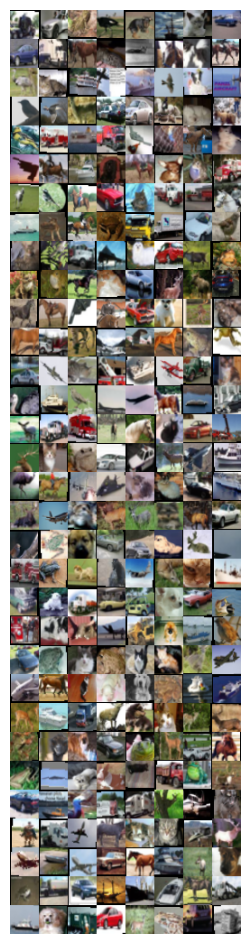

first raw classes truck automobile  frog  bird   dog  ship   cat automobile automobile truck horse   cat   cat horse   dog horse  bird   cat  ship airplane  ship  bird   dog airplane  bird  bird  deer automobile automobile horse   dog  deer
torch.Size([256, 3, 32, 32])


In [65]:
# get some random training images batch
dataiter = next(iter(trainloader))

# parse images and lables from batch
images, labels = dataiter

print(images.shape,labels.shape)

def imshow(images, nrow = 8,figsize=(16,12), mean=MEAN, std=STD):
    
    img = torchvision.utils.make_grid(images, nrow = nrow, padding = 0).to(device)

    img = img.transpose(2,0).transpose(0,1)

    std = torch.as_tensor(std).to(device)
    mean = torch.as_tensor(mean).to(device)
    img = (img * std + mean)# unnormalize 
    
    img = img.data.cpu().numpy()
       
    plt.figure(figsize=(16,12))
    plt.imshow(img); plt.axis('off'); plt.show()


images, labels = next(iter(trainloader))

imshow(images)

print('first raw classes',' '.join('%5s' % names_classes[labels[j]] for j in range(BATCH_SIZE//8)))

print(images.shape)

## Тест сети

В данном практикуме полезно будет использовать упрощенную версию базовой архитектуры. Это позволит ускорить ее обучение. 

Также полезным будет разделить модель на блоки. Выделим отдельно:
* Блок выделения признков (`feature_extractor`). 
* Операция приведения к принятию решений (`GAP`).
* Слой принятия решений (`fc`).

Блок `feature_extractor` содержит операции свертки, `MaxPool2d` и функцию активации `ReLU`.

> Обратите внимание на структуру `feature_extractor`, в ней нет операции `MaxPool2d` после второй свертки. Это связано с тем, что далее будет операция `GAP`.

In [173]:
class Model(nn.Module):
    
    def __init__(self, in_channels=3, n_classes=10):
        super().__init__()
        
        self.feature_extractor = nn.Sequential(
                         nn.Conv2d(in_channels  = in_channels, 
                                 out_channels = 6,
                                 stride = 1,  
                                 kernel_size  = 5), 
                         nn.ReLU(),   
                         nn.MaxPool2d(kernel_size = 2, 
                                 stride      = 2),   
                         nn.Conv2d(in_channels  = 6, 
                                 out_channels = 16,
                                 kernel_size  = 5), 
                         nn.ReLU() 
                        )

        
        # Global Average Pooling
        self.gap = nn.Sequential(
                    nn.AdaptiveAvgPool2d((1,1)),
                    nn.Flatten() 
                    )
        # classification       
        self.fc = nn.Linear(in_features = 16, 
                             out_features = n_classes)

        
    def forward(self, x):
 
        x = self.feature_extractor(x)  
        
        #flatten
        x = self.gap(x) 
        
        # output layer
        x = self.fc(x)
        
        return x#torch.softmax(x, dim=1)

In [174]:
model = Model(3,10)
# from torchsummary import summary
summary(model, input_size = (1,3,32,32))

Layer (type:depth-idx)                   Output Shape              Param #
Model                                    [1, 10]                   --
├─Sequential: 1-1                        [1, 16, 10, 10]           --
│    └─Conv2d: 2-1                       [1, 6, 14, 14]            456
│    └─ReLU: 2-2                         [1, 6, 14, 14]            --
│    └─Conv2d: 2-3                       [1, 16, 10, 10]           2,416
│    └─ReLU: 2-4                         [1, 16, 10, 10]           --
├─Sequential: 1-2                        [1, 16]                   --
│    └─AdaptiveAvgPool2d: 2-5            [1, 16, 1, 1]             --
│    └─Flatten: 2-6                      [1, 16]                   --
├─Linear: 1-3                            [1, 10]                   170
Total params: 3,042
Trainable params: 3,042
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 0.33
Input size (MB): 0.01
Forward/backward pass size (MB): 0.02
Params size (MB): 0.01
Estimated Total Size (MB): 0.

В собранном формате модель представляет собой комбинацию именнованных составляющих.


In [175]:
model

Model(
  (feature_extractor): Sequential(
    (0): Conv2d(3, 6, kernel_size=(5, 5), stride=(2, 2))
    (1): ReLU()
    (2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (3): ReLU()
  )
  (gap): Sequential(
    (0): AdaptiveAvgPool2d(output_size=(1, 1))
    (1): Flatten(start_dim=1, end_dim=-1)
  )
  (fc): Linear(in_features=16, out_features=10, bias=True)
)

Для такой модели, например, можно отдельно вызвать `feature_extractor`.

In [154]:
model.feature_extractor

Sequential(
  (0): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (4): ReLU()
)

Или можно отдельно получить результат работы модели.

In [155]:
x,y = next(iter(train_loader))
x.shape

torch.Size([256, 3, 32, 32])

In [156]:
with torch.inference_mode():
    model.eval(); 
    fe = model.feature_extractor(x)
    features = model.gap(fe)

    head =  model.fc(features)     
    print(fe.shape, features.shape, head.shape)

torch.Size([256, 16, 10, 10]) torch.Size([256, 16]) torch.Size([256, 10])


> Отметим, что теперь можно скомбинировать полученный `feature_extractor` c новой головной частью модели, например как это показано ниже.
>```python
    m2 = nn.Sequential(model.feature_extractor, 
                       model.gap, 
                       nn.Linear(16,10), 
                       nn.ReLU(), 
                       nn.Linear(10,10))
```

In [125]:
def train(model, dataloader, optimizer, criterion, metric,  device):

    epoch_loss = 0
    epoch_acc  = 0

    model.train()

    for (x, y) in tqdm(dataloader, desc="Training", leave=False):

        x, y = x.to(device), y.to(device)

        optimizer.zero_grad(set_to_none = True)

        y_pred = model(x)

        loss = criterion(y_pred, y)
        acc  = metric(y_pred, y)

        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        epoch_acc  += acc.item()

    return epoch_loss / len(dataloader), epoch_acc / len(dataloader)

def evaluate(model, dataloader, criterion, metric, device):

    epoch_loss = 0
    epoch_acc  = 0

    model.eval()

    with torch.inference_mode():
        
        for (x, y) in tqdm(dataloader, desc="Evaluating", leave=False):

            x, y = x.to(device), y.to(device)

            y_pred = model.forward(x)

            loss = criterion(y_pred, y)
            acc  = metric( y_pred, y)

            epoch_loss += loss.item()
            epoch_acc  += acc.item()

    return epoch_loss / len(dataloader), epoch_acc / len(dataloader)

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

def calculate_accuracy(y_pred, y):
    top_pred = y_pred.argmax(1, keepdim=True)
    correct = top_pred.eq(y.view_as(top_pred)).sum()
    acc = correct.float() / y.shape[0]
    return acc
def accuracy(y_pred, y):
    cls_pred = y_pred.argmax(1, keepdim=True)    
    correct_cls = cls_pred.eq(y.view_as(cls_pred)).sum()
    acc = correct_cls.float() / y.shape[0]
    return acc

In [126]:
LR = 0.003
model = Model(3,10)
criterion = nn.CrossEntropyLoss()
model     = model.to(device)
criterion = criterion.to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=LR, momentum=0.9)
metric    = accuracy


In [93]:
EPOCHS = 20

best_valid_loss = float('inf')

for epoch in trange(EPOCHS):

    start_time = time.monotonic()

    train_loss, train_acc = train(model, train_loader, optimizer, criterion, metric, device)
    valid_loss, valid_acc = evaluate(model, val_loader, criterion, metric, device)

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'best_model.pt')

    end_time = time.monotonic()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if epoch%2 == 1:    # print every 2 epochs:
        print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
        print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%',
        f'| Val. Loss: {valid_loss:.3f} | Val. Acc: {valid_acc*100:.2f}%')

  0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/176 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/127 [00:00<?, ?it/s]

Epoch: 01 | Epoch Time: 0m 27s
	Train Loss: 2.279 | Train Acc: 11.02% | Val. Loss: 2.230 | Val. Acc: 15.02%


Training:   0%|          | 0/176 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/127 [00:00<?, ?it/s]

Epoch: 02 | Epoch Time: 0m 27s
	Train Loss: 2.164 | Train Acc: 20.62% | Val. Loss: 2.083 | Val. Acc: 23.78%


Training:   0%|          | 0/176 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/127 [00:00<?, ?it/s]

Epoch: 03 | Epoch Time: 0m 27s
	Train Loss: 2.043 | Train Acc: 24.87% | Val. Loss: 1.997 | Val. Acc: 25.93%


Training:   0%|          | 0/176 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/127 [00:00<?, ?it/s]

Epoch: 04 | Epoch Time: 0m 28s
	Train Loss: 1.976 | Train Acc: 27.00% | Val. Loss: 1.929 | Val. Acc: 28.12%


Training:   0%|          | 0/176 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/127 [00:00<?, ?it/s]

Epoch: 05 | Epoch Time: 0m 28s
	Train Loss: 1.912 | Train Acc: 28.89% | Val. Loss: 1.857 | Val. Acc: 30.49%


Training:   0%|          | 0/176 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/127 [00:00<?, ?it/s]

Epoch: 06 | Epoch Time: 0m 30s
	Train Loss: 1.856 | Train Acc: 30.31% | Val. Loss: 1.808 | Val. Acc: 32.47%


Training:   0%|          | 0/176 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/127 [00:00<?, ?it/s]

Epoch: 07 | Epoch Time: 0m 28s
	Train Loss: 1.812 | Train Acc: 32.14% | Val. Loss: 1.777 | Val. Acc: 32.26%


Training:   0%|          | 0/176 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/127 [00:00<?, ?it/s]

Epoch: 08 | Epoch Time: 0m 31s
	Train Loss: 1.777 | Train Acc: 33.25% | Val. Loss: 1.741 | Val. Acc: 34.96%


Training:   0%|          | 0/176 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/127 [00:00<?, ?it/s]

Epoch: 09 | Epoch Time: 0m 26s
	Train Loss: 1.753 | Train Acc: 34.46% | Val. Loss: 1.716 | Val. Acc: 36.14%


Training:   0%|          | 0/176 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/127 [00:00<?, ?it/s]

Epoch: 10 | Epoch Time: 0m 26s
	Train Loss: 1.733 | Train Acc: 35.20% | Val. Loss: 1.699 | Val. Acc: 36.39%


In [94]:
model.load_state_dict(torch.load('best_model.pt'))
test_loss, test_acc = evaluate(model, test_loader, criterion, metric, device)
print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Test Loss: 1.698 | Test Acc: 36.99%


## Задания

__1.__ Перед обучением модели на большом наборе данных [иногда рекомендуется](https://stanford.edu/~shervine/teaching/cs-230/cheatsheet-deep-learning-tips-and-tricks#good-practices) выбрать минибатч, для которого проверяется что модель действительно работает и не дает сбоев.  __Предлагается__ проверить точность модели на подвыборке набора данных (например на одном батче). 
> Отметим, что нормальным размером батча считается 32 - 128 семплов.

__2.__ В том числе, на небольшом батче модель проверяется на предмет переобучения. Модель "нормальной" сложности должна переобучиться, если выбрать достаточно много эпох, не слишьком маленькую скорость обучения и другие гиперпараметры. __Предлагается__ переобучить модель на небольшом батче.

__3.__ Если модель переобучена, то ее следует вывести зи переобучения путем регуляризаций (увеличение набора данных, аугментация, нормализация / дропаут, и тд). __Предлагается__ проверить, как модель выйдет из состояния переобучения.

# Приемы обучения НС

## Инициализация обучения

Для повышения качества работы с моделями проведем инициализацию весовых параметров при помощи модуля [`nn.init`](https://pytorch.org/docs/stable/nn.init.html).

> Отметим, что в ряде случаев достаточно инициализации «по умолчанию». В других случаях лучше проводить рекомендованные схемы инициализации. Однако, пробуя вручную различные схемы инициализации, мы обычно можем добиться небольшого улучшения производительности.

Инициализируем параметры, создавая функцию, которая принимает модуль (слой) модели, проверяет, какого типа этот слой, а затем использует методы `nn.init` для инициализации параметров рекомендуемым способом.

В достаточно общем случае можно сказать, что инициализация имеет вид нормального или равномерного распределений с параметром (стандартным отклонением или разбросом), заданным:

$$\frac{\text{gain}}{\sqrt{\text{fan mode}}}$$

Значение $\text{gain}$ зависит от нелинейности, которая будет использована после слоя. Например, `ReLU` устанавливает $\text{gain}$ в $\sqrt{2}$. Значение $\text{fan mode}$ может быть либо `fan_in`, либо `fan_out`. `fan_in` — это количество соединений, входящих в слой, а `fan_out` — количество соединений, выходящих из слоя. Количество соединений — это количество параметров (оно есть не только у полносвязного слоя, но и у остальных слоев). Для линейного слоя можно записать названную инициализацию как $$\frac{\text{2}}{\sqrt{\text{fan in}+\text{fan out}}}$$     
> Например, для сверточного слоя на вход поступает фильтр 3x3x3, поэтому `fan_in` равно 27, а на выход — 64x3x3, поэтому `fan_out` равно 576. Эта схема инициализации называется *Kaiming Normal*, также известная как *Xe Normal*.

В `nn.init` есть функция `calculate_gain`, которая рассчитывает $\text{gain}$ для заданных функций активации.

При инициализации — инициализируем члены смещения нулями.

> Зачем вообще нужно инициализировать параметры? Мы хотим, чтобы выходы каждой функции активации (и, следовательно, входы последующего слоя) имели среднее значение 0 и стандартное отклонение 1. Тогда выход производной функций активации будет максимальным, а значения весов не приведет к вымыванию или взрыву градиента.

Подробней о рекомендациях инициализации смотрите [в документации](https://pytorch.org/docs/stable/nn.init.html).

In [95]:
def initialize_parameters(m):
    if isinstance(m, nn.Conv2d):
        nn.init.kaiming_normal_(m.weight.data, nonlinearity='relu')
        nn.init.constant_(m.bias.data, 0)
    elif isinstance(m, nn.Linear):
        nn.init.xavier_normal_(m.weight.data, gain=nn.init.calculate_gain('relu'))
        nn.init.constant_(m.bias.data, 0)

Применим инициализацию с помощью метода модели `apply`. Это вызовет заданную функцию на каждом модуле и подмодуле в модели.  

In [127]:
model.apply(initialize_parameters)

Model(
  (feature_extractor): Sequential(
    (0): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (4): ReLU()
  )
  (gap): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc): Linear(in_features=16, out_features=10, bias=True)
)

> Смотрите также примеры визуализации весовых параметров [при различных стратегиях инициализации](https://uvadlc-notebooks.readthedocs.io/en/latest/tutorial_notebooks/tutorial4/Optimization_and_Initialization.html?highlight=initialization) и [тут](https://www.deeplearning.ai/ai-notes/initialization/index.html).

## Поиск диапазона скоростей обучения

Проведем поиск оптимальной скорости обучения. 
Для этого используем готовую утилиту [pytorch-lr-finder](https://github.com/davidtvs/pytorch-lr-finder). 
<!-- Код здесь взят из урезанной и слегка модифицированной версии  [pytorch-lr-finder](https://github.com/davidtvs/pytorch-lr-finder).
```python
from torch.optim.lr_scheduler import _LRScheduler

class LRFinder:
    def __init__(self, model, optimizer, criterion, device):

        self.optimizer = optimizer
        self.model = model
        self.criterion = criterion
        self.device = device

        torch.save(model.state_dict(), 'init_params.pt')

    def range_test(self, iterator, end_lr=10, num_iter=100,
                   smooth_f=0.05, diverge_th=5):

        lrs = []
        losses = []
        best_loss = float('inf')

        lr_scheduler = ExponentialLR(self.optimizer, end_lr, num_iter)

        iterator = IteratorWrapper(iterator)

        for iteration in range(num_iter):

            loss = self._train_batch(iterator)

            lrs.append(lr_scheduler.get_last_lr()[0])

            # update lr
            lr_scheduler.step()

            if iteration > 0:
                loss = smooth_f * loss + (1 - smooth_f) * losses[-1]

            if loss < best_loss:
                best_loss = loss

            losses.append(loss)

            if loss > diverge_th * best_loss:
                print("Stopping early, the loss has diverged")
                break

        # reset model to initial parameters
        model.load_state_dict(torch.load('init_params.pt'))

        return lrs, losses

    def _train_batch(self, iterator):

        self.model.train()

        self.optimizer.zero_grad()

        x, y = iterator.get_batch()

        x = x.to(self.device)
        y = y.to(self.device)

        y_pred = self.model(x)

        loss = self.criterion(y_pred, y)

        loss.backward()

        self.optimizer.step()

        return loss.item()


class ExponentialLR(_LRScheduler):
    def __init__(self, optimizer, end_lr, num_iter, last_epoch=-1):
        self.end_lr = end_lr
        self.num_iter = num_iter
        super(ExponentialLR, self).__init__(optimizer, last_epoch)

    def get_lr(self):
        curr_iter = self.last_epoch
        r = curr_iter / self.num_iter
        return [base_lr * (self.end_lr / base_lr) ** r
                for base_lr in self.base_lrs]


class IteratorWrapper:
    def __init__(self, iterator):
        self.iterator = iterator
        self._iterator = iter(iterator)

    def __next__(self):
        try:
            inputs, labels = next(self._iterator)
        except StopIteration:
            self._iterator = iter(self.iterator)
            inputs, labels, *_ = next(self._iterator)

        return inputs, labels

    def get_batch(self):
        return next(self)

def plot_lr_finder(lrs, losses, skip_start=5, skip_end=5):

    if skip_end == 0:
        lrs = lrs[skip_start:]
        losses = losses[skip_start:]
    else:
        lrs = lrs[skip_start:-skip_end]
        losses = losses[skip_start:-skip_end]

    fig = plt.figure(figsize=(16, 8))
    ax = fig.add_subplot(1, 1, 1)
    ax.plot(lrs, losses)
    ax.set_xscale('log')
    ax.set_xlabel('Learning rate')
    ax.set_ylabel('Loss')
    ax.grid(True, 'both', 'x')
    plt.show()

    best_lr = lrs[np.argmin(losses)]

    print(f'Best lr = {best_lr:.5f}')

    return best_lr

best_lr = plot_lr_finder(lrs, losses)
``` -->

**Примечание**: поиск скорости обучения — это скорее искусство, чем наука. Алгоритм не сможет найти точную скорость обучения с точностью до $5$ знаков после запятой, которая всегда будет давать нам $100\%$ точность — но обычно это будет лучше, чем просто выбрать скорость обучения из воздуха.  

Наиболее часто используемый оптимизатор — `Adam`. Скорость обучения `Adam` по умолчанию обычно является отличным выбором, но, подобно тому, как вручную инициализировали параметры, чтобы потенциально получить некоторое улучшение производительности, мы можем попытаться рассчитать оптимальную скорость обучения вручную.  

Как работает система поиска скорости обучения? В алгоритм `finder` подается модель, оптимизатор и критерий, который хотелось бы использовать. Оптимизатору задается скорость обучения с гораздо меньше, чем предполагается использовать. Затем обучаются модели на данных из обучающего набора — вычисляются потери и обновляются параметры. После каждой партии экспоненциально увеличивается скорость обучения. Так делается вплоть до заданного верхнего предела. Это повторяется до тех пор, пока значения функции потерь не начинают расходится более чем в 5 раз по сравнению с наилучшими потерями или пока не достигнута максимальная скорость обучения.  

Вычисленные функции потерь обычно довольно шумные, поэтому сохраняется экспоненциальное среднее значений по батчам.  

При настоящем обучении необходимо использовать инициализированные параметры, а не те, которые были обновлены в результате поиска скорости обучения. Поэтому сохраним параметры модели на диск при инициализации алгоритма поиска, а затем сбросим их на желаемые инициализированные параметры непосредственно перед возвратом функции `range_test`, загружая начальные значения с диска.

Сначала создается экземпляр класса `finder` с моделью, оптимизатором и функцией потерь. Затем мы используем `range_test` с обучающим итератором, максимальной скоростью обучения и количеством итераций, которые мы хотим использовать. 

In [97]:
# !pip3 install torch_lr_finder
from torch_lr_finder import LRFinder

  0%|          | 0/200 [00:00<?, ?it/s]

Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 9.44E-04


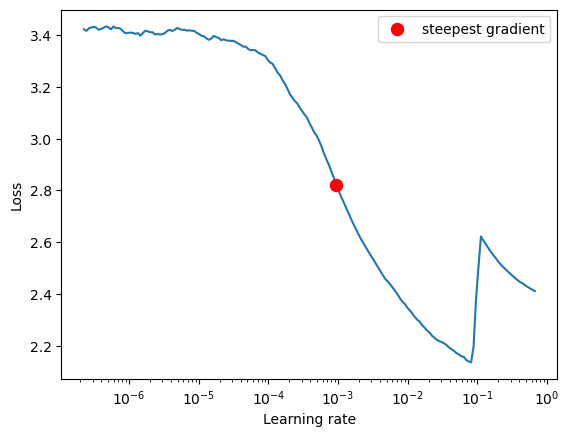

In [128]:
START_LR = 1e-7
model = Model(3,10)
model.apply(initialize_parameters)
criterion = nn.CrossEntropyLoss()

model = model.to(device)
criterion = criterion.to(device)


optimizer = optim.Adam(model.parameters(), lr=START_LR)
lr_finder = LRFinder(model, optimizer, criterion)
lr_finder.range_test(train_loader, end_lr=1, num_iter=200)
lr_finder.plot() # to inspect the loss-learning rate graph
lr_finder.reset() # to reset the model and optimizer to their initial state


Проверим точность для найденной скорости обучения. Отметим, что найденная скорость - это скорее правильный порядок скорости обучения, нежели чем точное значение. В данном случае порядок можно оценить как $0.001 - 0.1$.

In [129]:
model = Model()
model.apply(initialize_parameters)
model = model.to(device)
criterion = criterion.to(device)

optimizer = optim.Adam(model.parameters(), lr=0.01)

In [130]:
EPOCHS = 10

best_valid_loss = float('inf')

for epoch in trange(EPOCHS):

    start_time = time.monotonic()

    train_loss, train_acc = train(model, train_loader, optimizer, criterion, metric, device)
    valid_loss, valid_acc = evaluate(model, val_loader, criterion, metric, device)

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'best_model.pt')

    end_time = time.monotonic()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if epoch%2 == 1:    # print every 2 epochs:
        print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
        print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%',
        f'| Val. Loss: {valid_loss:.3f} | Val. Acc: {valid_acc*100:.2f}%')

  0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/176 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/127 [00:00<?, ?it/s]

Training:   0%|          | 0/176 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/127 [00:00<?, ?it/s]

Epoch: 02 | Epoch Time: 0m 26s
	Train Loss: 1.722 | Train Acc: 35.07% | Val. Loss: 1.625 | Val. Acc: 39.43%


Training:   0%|          | 0/176 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/127 [00:00<?, ?it/s]

Training:   0%|          | 0/176 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/127 [00:00<?, ?it/s]

Epoch: 04 | Epoch Time: 0m 29s
	Train Loss: 1.578 | Train Acc: 41.63% | Val. Loss: 1.535 | Val. Acc: 42.79%


Training:   0%|          | 0/176 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/127 [00:00<?, ?it/s]

Training:   0%|          | 0/176 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/127 [00:00<?, ?it/s]

Epoch: 06 | Epoch Time: 0m 30s
	Train Loss: 1.495 | Train Acc: 45.61% | Val. Loss: 1.480 | Val. Acc: 45.83%


Training:   0%|          | 0/176 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/127 [00:00<?, ?it/s]

Training:   0%|          | 0/176 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/127 [00:00<?, ?it/s]

Epoch: 08 | Epoch Time: 0m 28s
	Train Loss: 1.468 | Train Acc: 46.79% | Val. Loss: 1.441 | Val. Acc: 47.76%


Training:   0%|          | 0/176 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/127 [00:00<?, ?it/s]

Training:   0%|          | 0/176 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/127 [00:00<?, ?it/s]

Epoch: 10 | Epoch Time: 0m 27s
	Train Loss: 1.431 | Train Acc: 48.28% | Val. Loss: 1.367 | Val. Acc: 50.70%


In [131]:
model.load_state_dict(torch.load('best_model.pt'))

test_loss, test_acc = evaluate(model, test_loader, criterion, metric, device)

print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Test Loss: 1.451 | Test Acc: 48.58%


## Оптимизация параметров обучения по блокам

При обучении моделей часто оказывается желательным проведение [настройки параметров обучения](https://pytorch.org/docs/stable/optim.html#module-torch.optim).
Например, в ряде случаев полезным оказывается использование отдельных параметров обучения для экстрактора признаков и его головной части. Этот прием будет еще упомянут в разделе перенос признаков. Тут, однако, тоже его отметим. Прием использования различных скоростей обучения позволяет регулировать интенсивность обучения. Например, если мы ожидаем, что часть нейронной сети предобучена, то для нее скорость обучения должна быть гораздо ниже (если предобученные слои вообще нуждаются в обучении). 

> Часто при использовании предобученных сетей используется гипотеза заключается в том, что ранние слои нейронной сети учатся извлекать более общие признаки, в то время как поздние слои учатся извлекать более специфичные для конкретной задачи признаки. Если это так, то общие признаки, извлекаемые ранними слоями, должны быть полезны для любой задачи, и мы должны изменять их предварительно обученные веса на очень небольшую величину — если вообще должны.

> Дискриминативную тонкую настройку параметров обучения обычно нет необходимости использовать при обучении модели на основе случайно инициализированных весов.


In [162]:
model = Model()
model.apply(initialize_parameters)
model = model.to(device)
criterion = criterion.to(device)

LR = 1e-2;

params = [
          {'params': model.feature_extractor.parameters(), 'lr': LR / 2},
          {'params': model.fc.parameters(), 'lr': LR }
         ]

optimizer = optim.Adam(params, lr=LR)

> Отметим, что могут быть вырабнны и другие функции потерь, например см. [тут](https://kevinmusgrave.github.io/pytorch-metric-learning/).

In [163]:
EPOCHS = 10

best_valid_loss = float('inf')

for epoch in trange(EPOCHS):

    start_time = time.monotonic()

    train_loss, train_acc = train(model, train_loader, optimizer, criterion, metric, device)
    valid_loss, valid_acc = evaluate(model, val_loader, criterion, metric, device)

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'best_model.pt')

    end_time = time.monotonic()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%',
    f' | Val. Loss: {valid_loss:.3f} | Val. Acc: {valid_acc*100:.2f}%')

  0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/176 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/127 [00:00<?, ?it/s]

Epoch: 01 | Epoch Time: 0m 27s
	Train Loss: 2.036 | Train Acc: 23.90%  | Val. Loss: 1.805 | Val. Acc: 31.79%


Training:   0%|          | 0/176 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/127 [00:00<?, ?it/s]

Epoch: 02 | Epoch Time: 0m 27s
	Train Loss: 1.754 | Train Acc: 34.73%  | Val. Loss: 1.674 | Val. Acc: 37.63%


Training:   0%|          | 0/176 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/127 [00:00<?, ?it/s]

Epoch: 03 | Epoch Time: 0m 31s
	Train Loss: 1.669 | Train Acc: 38.40%  | Val. Loss: 1.589 | Val. Acc: 42.03%


Training:   0%|          | 0/176 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/127 [00:00<?, ?it/s]

Epoch: 04 | Epoch Time: 0m 27s
	Train Loss: 1.609 | Train Acc: 41.20%  | Val. Loss: 1.541 | Val. Acc: 43.91%


Training:   0%|          | 0/176 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/127 [00:00<?, ?it/s]

Epoch: 05 | Epoch Time: 0m 28s
	Train Loss: 1.572 | Train Acc: 42.97%  | Val. Loss: 1.518 | Val. Acc: 45.21%


Training:   0%|          | 0/176 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/127 [00:00<?, ?it/s]

Epoch: 06 | Epoch Time: 0m 31s
	Train Loss: 1.541 | Train Acc: 44.39%  | Val. Loss: 1.509 | Val. Acc: 45.46%


Training:   0%|          | 0/176 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/127 [00:00<?, ?it/s]

Epoch: 07 | Epoch Time: 0m 31s
	Train Loss: 1.515 | Train Acc: 45.31%  | Val. Loss: 1.495 | Val. Acc: 46.04%


Training:   0%|          | 0/176 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/127 [00:00<?, ?it/s]

Epoch: 08 | Epoch Time: 0m 32s
	Train Loss: 1.486 | Train Acc: 46.59%  | Val. Loss: 1.468 | Val. Acc: 46.37%


Training:   0%|          | 0/176 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/127 [00:00<?, ?it/s]

Epoch: 09 | Epoch Time: 0m 32s
	Train Loss: 1.477 | Train Acc: 47.09%  | Val. Loss: 1.445 | Val. Acc: 47.66%


Training:   0%|          | 0/176 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/127 [00:00<?, ?it/s]

Epoch: 10 | Epoch Time: 0m 35s
	Train Loss: 1.460 | Train Acc: 47.86%  | Val. Loss: 1.408 | Val. Acc: 49.57%


In [164]:
test_loss, test_acc = evaluate(model, test_loader, criterion, metric, device)

print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Test Loss: 1.442 | Test Acc: 48.92%


## Планировщик скорости обучения

Другим полезным приемом будет использовать [планировщик скорости обучения](https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate) `learning rate scheduler`. Планировщик скорости обучения динамически изменяет скорость обучения во время обучения модели. 
 
В наиболее простом случае планировщик скорости обучения задается из пакета `torch.optim.lr_scheduler` как одноцикловой планировщик. То есть он имеет только один цикл изменения скорости. 

Ниже показан пример визуализации для 4 типов планировщиков. 

> Обратите внимание, что текущее значение скорости обучения можно получить как `optimizer.param_groups[0]["lr"]`. Аналогичным образом мы его возвращаем после каждого цикла оптимизатора. 



In [165]:
LR_START = 0.02
optimizer = optim.SGD(model.parameters(), lr=LR_START, momentum=0.9)

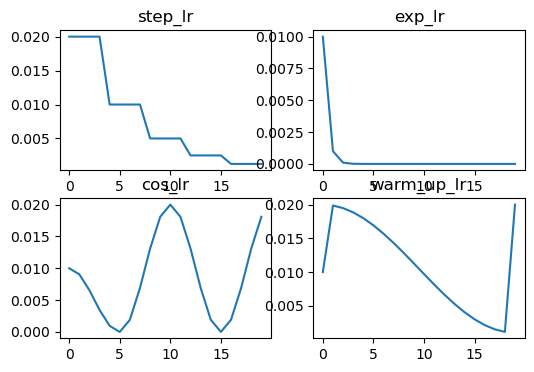

In [166]:
epochs = 20


schedulers = {'step_lr':torch.optim.lr_scheduler.StepLR(optimizer, step_size=4, gamma=0.5),
              'exp_lr':torch.optim.lr_scheduler.ExponentialLR(optimizer,  gamma=0.1),              
              'cos_lr':torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=5, eta_min=0),
              'warm_up_lr':torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, 
                                                                   T_0=19, T_mult=1, 
                                                                   eta_min=0.001)}

lrs = np.zeros((len(schedulers), epochs))
fig, axs = plt.subplots(2,2,figsize=(6,4));

with torch.inference_mode():
     
    for j, (k,scheduler) in enumerate(zip(schedulers.keys(), schedulers.values())):

        for i in range(epochs):
            optimizer.step()
            lrs[j,i] = optimizer.param_groups[0]["lr"]
            scheduler.step()
        optimizer.param_groups[0]["lr"]  = 0.01
        axs.ravel()[j].plot(range(epochs),lrs[j]); 
        axs.ravel()[j].set_title(k);


<blockquote>
    
Отметим, что также может быть использован планировщик `ReduceLROnPlateau`, который снижает скорость обучения автоматически при выходе валидации на плато.
    
```python

    optimizer = torch.optim.SGD(model.parameters(), lr=0.1, momentum=0.9)
    scheduler = ReduceLROnPlateau(optimizer, 'min')
    for epoch in range(10):
        train(...)
        val_loss = validate(...)
        # Note that step should be called after validate()
        scheduler.step(val_loss)
```

Дополним функцию тренировки новым аргументом `scheduler`.

In [167]:
def train(model, dataloader, optimizer, criterion, metric, scheduler=None,  device = 'cpu'):

    epoch_loss = 0
    epoch_acc  = 0

    model.train()

    for (x, y) in tqdm(dataloader, desc="Training", leave=False):

        x, y = x.to(device), y.to(device)

        optimizer.zero_grad(set_to_none = True)

        y_pred = model(x)

        loss = criterion(y_pred, y)
        acc  = metric( y_pred, y)

        loss.backward()
        
#         torch.nn.utils.clip_grad_norm_(model.parameters(), 1., norm_type= 2)
        
        optimizer.step()                

        epoch_loss += loss.item()
        epoch_acc  += acc.item()
    
    if scheduler != None:
        scheduler.step()
        
    return epoch_loss / len(dataloader), epoch_acc / len(dataloader)

Проверим работу расписания. 

Следует также отметить, что помимо расписания ниже приведен следующий код:
```python
    max_grad = 10
    for p in model.parameters():
        p.register_hook(lambda grad: torch.clamp(grad, -0.1, max_grad))
```

Такой прием позволяет ограничить значение градиента (`gradient clipping`): `lambda grad: torch.clamp(grad, -0.1, max_grad)`. Прием применяется для всех параметров, так как задан цикл. При этом данный прием записывается как дополнительная функция при расчете градиента. Это реализовано через т.н. `hook`. По средствам метода `register_hook` подобно `callback` каждому параметру ставится дополнительная функция в соответствие.

Отметим, что можно бы было провести `gradient clipping` при помощи встроенной утилиты `torch.nn.utils.clip_grad_norm_`. В функции `train` выше эта строка закомментирована. 

In [170]:
LR_PERIOD = 2
LR_DECAY  = 0.9
LR = 0.012;


model = Model()
model = model.to(device)
criterion = criterion.to(device)

model.apply(initialize_parameters)

max_grad = 10
for p in model.parameters():
    p.register_hook(lambda grad: torch.clamp(grad, -0.1, max_grad))

optimizer = optim.Adam(model.parameters(), lr=LR)

scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 
                                            step_size = LR_PERIOD, 
                                            gamma     = LR_DECAY)


In [171]:
EPOCHS = 10

best_valid_loss = float('inf')

for epoch in trange(EPOCHS):

    start_time = time.monotonic()

    train_loss, train_acc = train(model, train_loader, optimizer, criterion, metric, scheduler)
    valid_loss, valid_acc = evaluate(model, val_loader, criterion, metric, device)

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'best_model.pt')

    end_time = time.monotonic()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    if epoch%2 == 1:    # print every 2 epochs:
        print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s | LR {optimizer.param_groups[0]["lr"] :.4f}')
        print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%',
        f' | Val. Loss: {valid_loss:.3f} | Val. Acc: {valid_acc*100:.2f}%')

  0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/176 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/127 [00:00<?, ?it/s]

Training:   0%|          | 0/176 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/127 [00:00<?, ?it/s]

Epoch: 02 | Epoch Time: 0m 33s | LR 0.0108
	Train Loss: 1.807 | Train Acc: 30.38%  | Val. Loss: 1.722 | Val. Acc: 34.97%


Training:   0%|          | 0/176 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/127 [00:00<?, ?it/s]

Training:   0%|          | 0/176 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/127 [00:00<?, ?it/s]

Epoch: 04 | Epoch Time: 0m 39s | LR 0.0097
	Train Loss: 1.657 | Train Acc: 37.90%  | Val. Loss: 1.625 | Val. Acc: 38.85%


Training:   0%|          | 0/176 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/127 [00:00<?, ?it/s]

Training:   0%|          | 0/176 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/127 [00:00<?, ?it/s]

Epoch: 06 | Epoch Time: 0m 30s | LR 0.0087
	Train Loss: 1.594 | Train Acc: 40.87%  | Val. Loss: 1.583 | Val. Acc: 40.78%


Training:   0%|          | 0/176 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/127 [00:00<?, ?it/s]

Training:   0%|          | 0/176 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/127 [00:00<?, ?it/s]

Epoch: 08 | Epoch Time: 0m 29s | LR 0.0079
	Train Loss: 1.559 | Train Acc: 42.85%  | Val. Loss: 1.513 | Val. Acc: 44.18%


Training:   0%|          | 0/176 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/127 [00:00<?, ?it/s]

Training:   0%|          | 0/176 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/127 [00:00<?, ?it/s]

Epoch: 10 | Epoch Time: 0m 28s | LR 0.0071
	Train Loss: 1.543 | Train Acc: 43.60%  | Val. Loss: 1.491 | Val. Acc: 45.76%


In [172]:
test_loss, test_acc = evaluate(model, test_loader, criterion, metric, device)
print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Test Loss: 1.522 | Test Acc: 45.19%


<!-- https://pytorch.org/vision/main/auto_examples/transforms/plot_cutmix_mixup.html#sphx-glr-auto-examples-transforms-plot-cutmix-mixup-py
from torchvision.transforms import v2
NUM_CLASSES = 10
alpha  = 0.5

cutmix = v2.CutMix(num_classes=NUM_CLASSES, alpha = alpha)
mixup = v2.MixUp(num_classes=NUM_CLASSES, alpha = alpha)
cutmix_or_mixup = v2.RandomChoice([cutmix, mixup])

for images, labels in train_loader:
    images = images.reshape(-1,1,28,28)
    print(f"Before CutMix/MixUp: {images.shape = }, {labels.shape = }")
    images, labels = cutmix_or_mixup(images, labels)
    print(f"After  CutMix/MixUp: {images.shape = }, {labels.shape = }")
    
    targets1, targets2 = 
    loss = alpha * criterion(preds, targets1) + (1 - self.alpha) * criterion(preds, targets2)

    break
    
targets = torch.nonzero(labels).reshape(-1,4)[:,1::2]
    
images = images.reshape(-1,1,28,28)
batch = torchvision.utils.make_grid(images, nrow = int(np.sqrt(images.shape[0])), padding = 0)
vis_batch = batch.data.numpy().transpose((1, 2, 0))*255
plt.imshow(vis_batch); 
plt.axis('off');
plt.show()
images.shape, batch.shape,  vis_batch.shape  

class CutMixCELoss(nn.Module):
    def __init__(self, alpha = 0.5):
        super(CutMixCELoss, self).__init__() 
        self.criterion = nn.CrossEntropyLoss
        self.alpha = alpha

    def farward(self, preds, targets):
        targets1, targets2  = targets
        return self.alpha * self.criterion(preds, targets1)\
            + (1 - self.alpha) * self.criterion(preds, targets2)
            
```python
    from torch.utils.data import default_collate

    def collate_fn(batch):
        return cutmix_or_mixup(*default_collate(batch))
    
    
    dataloader = DataLoader(dataset, batch_size=4, shuffle=True, num_workers=2, collate_fn=collate_fn) -->

## Задания

**1.** Проверьте, как влияют те или иные режимы инициализации на качество работы нейронной сети. Например, инициализация постоянными величинами `nn.init.constant_(m.weight, constant_weight)`.

__2.__  В ряде [случаев](https://discuss.pytorch.org/t/tricks-for-being-able-to-use-a-higher-learning-rate/142179) рекомендуется стратегия обучения, когда изначально используется крайне низкая скорость обучения в течение нескольких эпох, чтобы веса модели настроились в нужном направлении. Такие эпохи будут сравнительно бесполезными с точки зрения результата обучения, но повышают стабильность экспериментов. Затем скорость обучения резко увеличивают и начинают плавно снижать. Предполагается, что после первоначальной настройки весов они могут быстро обучиться в нужном направлении. __Предлагается__ реализовать эту стратегию самостоятельно.

> Также иногда используют циклическую скорость обучения для большого числа эпох.

<code style="color : red">__3.*__</code> В ряде [работ](https://openreview.net/pdf?id=B1Yy1BxCZ) рекомендуется вместе с изменением скорости обучения (с ее снижением) [увеличивать размер батча](https://stackoverflow.com/questions/53033556/how-should-the-learning-rate-change-as-the-batch-size-change). __Предлагается__ реализовать эту стратегию обучения самостоятельно. 

> [Иногда](https://ar5iv.labs.arxiv.org/abs/1803.09820) также рекомендуют уменьшать затухание весов с ростом эпохи обучения (параметр `L2` регуляризации — `weight_decay` в оптимизаторах). Если используется параметр `momentum`, то он должен снижаться с увеличением скорости обучения [или циркулировать](https://ar5iv.labs.arxiv.org/abs/1803.09820).

<code style="color : red">__4.*__</code> Настройка параметров обучения может быть выполнена не только по блокам модели, но и по отдельным параметрам. Например, если используется `SGD with weight_decay`, иногда полезно отключить `weight_decay` для параметра смещения. Это можно сделать следующим образом.
    
```python
    bias_params = [p for name, p in self.named_parameters() if 'bias' in name]
    others = [p for name, p in self.named_parameters() if 'bias' not in name]

    optim.SGD([
                    {'params': others},
                    {'params': bias_params, 'weight_decay': 0}
                ], weight_decay=1e-2, lr=1e-2)
```
> Отметим, что также [в ряде случаев](https://github.com/NVIDIA/DeepLearningExamples/blob/8d8b21a933fff3defb692e0527fca15532da5dc6/PyTorch/Classification/ConvNets/image_classification/training.py)  'weight_decay' не используется для параметров батч-нормализации.

__Предлагается__ проверить качество такого оптимизатора самостоятельно.

<code style="color : red">__5.*__</code> Иногда в функцию потерь также добавляют параметр [`label_smoothing`](https://paperswithcode.com/method/label-smoothing), выставляя его небольшим. При этом итоговая метка класса формируется как $$ y_s = (1-\eta y) + U[0, \eta/K] $$ где $\eta$ — весовой коэффициент, $K$ — число классов, а $U[0, \eta/K]$ — равномерное распределение. То есть $y_s$ представляет собой вектор, где основной класс имеет значение в диапазоне $(0,1)$, а остаток этого диапазона «размыт» между значениями остальных классов. В таком случае ожидается, что подразумеваемая функция активации $softmax$ не будет выходить в насыщение, что снизит вероятность переобучения слоя принятия решений. Сегодня `label_smoothing` в оригинальной функции потерь, как это показано ниже. __Предлагается__ попробовать использовать эту функцию самостоятельно.

```python 
    nn.CrossEntropyLoss(label_smoothing = ...)
```